https://machinelearningmastery.com/lstm-autoencoders/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. MinMax scalar
2. Different loss functions
3. How to take output of encoder part

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [ ]:
!pip install -U umap-learn
import umap

     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 22.8MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=59e4788d0deeeedb34e1973e045ad7f3b4720bee234cc78b83aaaec52e98fb80
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=33922884388b0ae5a23cdf9f77fadb3129f23ac1bd24035265669a54aa4b5f2c
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=bc2359a144f5041a5aa635392e8f0c6a1dbfe30e459810f1575d68fd23a23e6e
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=270cc527d33c28b00e5b117aaa46061ec79ec89fdc1d8e847e0c0d20f188ab0d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
plt.rcParams["figure.figsize"] = [16,9]
train_test_flag = False

In [ ]:
# _initializing constant variables
if train_test_flag:
  input_file_path = f'/content/drive/MyDrive/Colab Notebooks/processed_data_train.csv'
  output_filename_features = f'UCIHAR_sensor_features_lstm_tuned_train.csv'
  output_filename_activity = f'activity_subject_data_train.csv'
else:
  input_file_path = f'/content/drive/MyDrive/Colab Notebooks/processed_data_test.csv'
  output_filename_features = f'UCIHAR_sensor_features_lstm_tuned_test.csv'
  output_filename_activity = f'activity_subject_data_test.csv'

col_names = ['subject_id', 'activityID', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
main_df = pd.read_csv(input_file_path, names=col_names)

1 WALKING

2 WALKING_UPSTAIRS

3 WALKING_DOWNSTAIRS

4 SITTING

5 STANDING

6 LAYING


In [ ]:
main_df

,subject_id,activityID,X1,Y1,Z1,X2,Y2,Z2
0,1.0,5.0,1.041216,-0.269796,0.023780,0.437464,0.531349,0.136528
1,1.0,5.0,1.041803,-0.280025,0.076293,0.468264,0.721069,0.097622
2,1.0,5.0,1.039086,-0.292663,0.147475,0.498257,0.520328,0.083556
3,1.0,5.0,1.054768,-0.292384,0.139906,0.479396,0.372625,0.022861
4,1.0,5.0,1.028376,-0.285826,0.119934,0.389894,0.414541,-0.025939
...,...,...,...,...,...,...,...,...
377211,2947.0,2.0,0.908386,-0.423054,-0.092933,0.148295,-0.015923,0.109040
377212,2947.0,2.0,0.898984,-0.392272,-0.063138,0.143136,-0.024389,0.006547
377213,2947.0,2.0,0.918862,-0.351680,-0.072539,0.095931,-0.021024,-0.051342
377214,2947.0,2.0,0.949475,-0.267526,-0.050975,0.090708,-0.041893,-0.078877


In [ ]:
#main_df[['subject_id', 'activityID', 'X1']].groupby(['subject_id', 'activityID']).agg(['count'])

In [ ]:
#main_df = main_df.loc[main_df['subject_id'] != 103]

In [ ]:
#main_df.sort_values(by=['activityID'], inplace=True)
#main_df[['subject_id','activityID']].groupby(['activityID']).agg(['count'])

In [ ]:
#drop_cols = ['subject_id']
#main_df.drop(columns=drop_cols, axis=1, inplace=True)
subjects = set(list(main_df.subject_id.unique()))
print(len(subjects))

2947


In [ ]:
main_df.shape

(377216, 8)

In [ ]:
window_size = 16
window_overlap = 8
timesteps = window_size
max_window_index = 128
features = 6

In [ ]:
sensor_data = main_df.iloc[:, 2:].values.astype('float32')
print(sensor_data.shape)

(377216, 6)


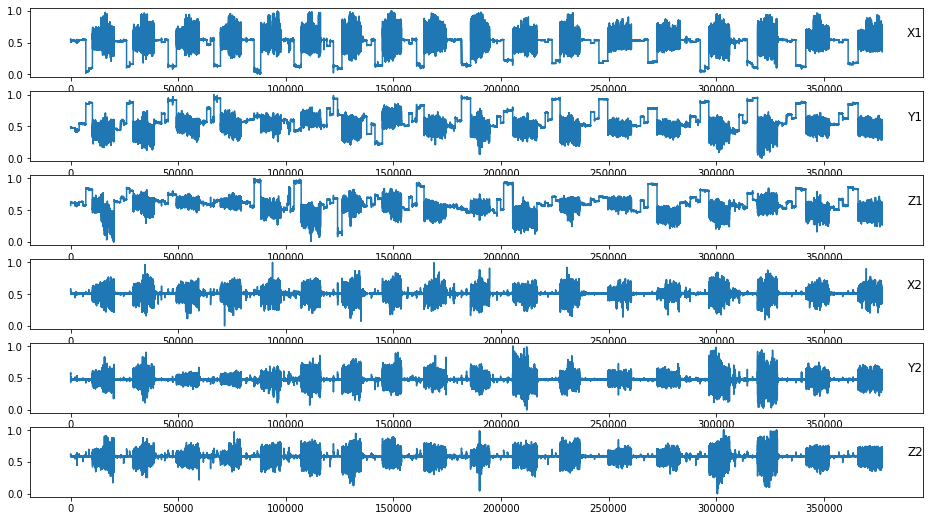

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for idx in range(features):
    sensor_data[:, idx] = MinMaxScaler().fit_transform(sensor_data[:, idx].reshape(-1, 1)).reshape(1,-1)

plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+2], y=0.5, loc='right')

plt.show()

In [ ]:
def get_window_data(instance_data):

  instance_data = instance_data.reshape(6, 128)
  window_index = 0
  sub_sequences = [[] for i in range(6)]

  while window_index <= (max_window_index - window_size):

      for idx in range(6):
          sub_sequences[idx].append(instance_data[idx][window_index:window_index+window_size].tolist())

      window_index += window_overlap

  sub_sequences = np.array(sub_sequences).reshape(-1, 6, 16)
  return sub_sequences

In [ ]:
activity_subject_df = main_df[['activityID', 'subject_id']].drop_duplicates().values.astype('int32')
activity_sequences = []
sensor_sequences = np.array([])

for instance in activity_subject_df:
  activity = instance[0]
  subject = instance[1]
  instance_data = main_df.loc[(main_df['subject_id'] == subject) & (main_df['activityID'] == activity)]
  subsequence_data = get_window_data(instance_data[col_names[2:]].values)

  for val in range(subsequence_data.shape[0]):
    activity_sequences.append([subject, activity])

  if sensor_sequences.size == 0:
    sensor_sequences = subsequence_data
  else:
    sensor_sequences = np.vstack((sensor_sequences, subsequence_data))  

In [ ]:
assert len(activity_sequences) == sensor_sequences.shape[0]
sensor_sequences.shape

(44205, 6, 16)

In [ ]:
# _input data format - [samples, timesteps, features]
features = 1
sensor_data = sensor_sequences[:, 0]
sensor_data = sensor_data.reshape(-1, timesteps, features)

for col in range(1, 6):
  sensor_data_channel = sensor_sequences[:, col]
  sensor_data_channel = sensor_data_channel.reshape(-1, timesteps, features)

  sensor_data = np.vstack((sensor_data, sensor_data_channel))  
  
sensor_data.shape

(265230, 16, 1)

In [ ]:
def build_model(hp):

    lstm_layer_1_output_params = hp.Int(
        'output_1', min_value=80, max_value=120, step=5)
    lstm_layer_2_output_params = hp.Int(
        'output_2', min_value=50, max_value=80, step=5)
    
    lstm_layer_1_dropoutrate_params = hp.Float(
        'dropoutrate_1', min_value=0.2, max_value=0.6, step=0.1)
    lstm_layer_2_dropoutrate_params = hp.Float(
        'dropoutrate_2', min_value=0.2, max_value=0.6, step=0.1)

    activation_fn_params = hp.Choice(
        'act_fn', values=['relu', 'tanh'])

    learning_rate_params = hp.Choice(
        'learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, input_shape=(timesteps, features), return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=False),
        tf.keras.layers.Dropout(rate=lstm_layer_1_dropoutrate_params),

        tf.keras.layers.RepeatVector(timesteps),

        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.Dropout(rate=lstm_layer_2_dropoutrate_params),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_params),loss='mse')

    return model

In [ ]:
tuner_bo = kt.tuners.BayesianOptimization(
                build_model,objective=kt.Objective('val_loss', direction="min"), max_trials = 10, executions_per_trial=2
)

# tuner_bo.search(sensor_data, sensor_data, epochs=3, batch_size=64 ,validation_split=0.3)
# best_model = tuner_bo.get_best_models(num_models=1)[0]
# print(best_model.summary()) 

# best_hp = tuner_bo.get_best_hyperparameters()[0]
# print(best_hp.values)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=10, 
    restore_best_weights=True,
)

#history = best_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

In [ ]:
lstm_ae_model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(100, activation='tanh', input_shape=(timesteps, features), return_sequences=True),
     tf.keras.layers.LSTM(60, activation='tanh', return_sequences=False),
     tf.keras.layers.Dropout(rate=0.2),

     tf.keras.layers.RepeatVector(timesteps),

     tf.keras.layers.LSTM(60, activation='tanh', return_sequences=True),
     tf.keras.layers.LSTM(100, activation='tanh', return_sequences=True),
     tf.keras.layers.Dropout(rate=0.5),

     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
 ])
lstm_ae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
lstm_ae_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 60)            29040     
_________________________________________________________________
lstm_7 (LSTM)                (None, 16, 100)           64400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 100)          

In [ ]:
#history = lstm_ae_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=64)
#best_model = lstm_ae_model

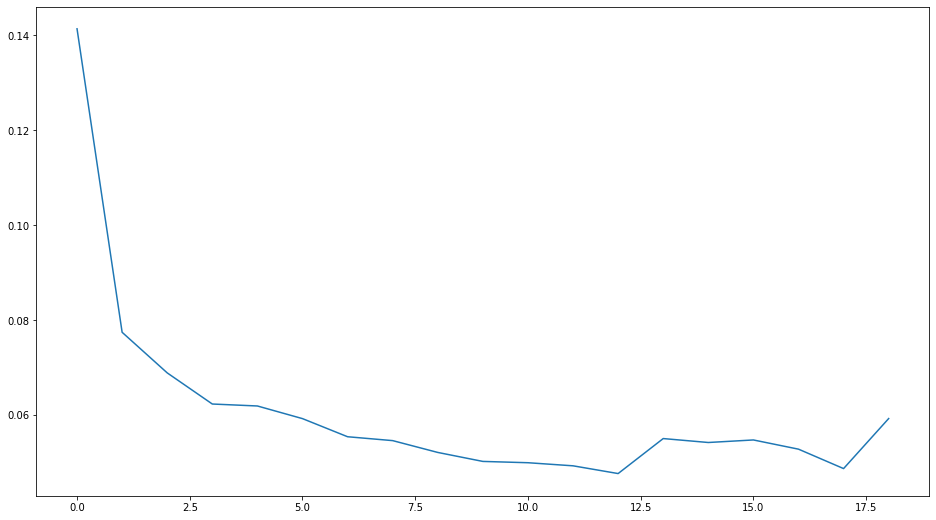

In [ ]:
#lstm_ae_model.save('channel_independent.h5')
plt.plot(history.history['loss'])
plt.show()

In [ ]:
sensor_data.shape

(265230, 16, 1)

In [ ]:
#!mkdir -p saved_model
#lstm_ae_model.save('saved_model/my_model') 

In [ ]:
#best_model = tf.keras.models.load_model('/content/drive/MyDrive/Classroom/channel_independent/') 

In [ ]:
get_2rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[2].output])

In [ ]:
def get_umap_data(data):
    
    data = MinMaxScaler().fit_transform(data)
    model_umap = umap.UMAP(n_neighbors = 100, min_dist = 0.1, n_components = 4)
    umap_vec = model_umap.fit_transform(data)

    return umap_vec

In [ ]:
final_features = None
for col in range(6):
  sensor_data_channel = sensor_sequences[:, col]
  sensor_data_channel = sensor_data_channel.reshape(-1, timesteps, features)

  encoder_output = get_2rd_layer_output(sensor_data_channel)
  sensor_features = np.asarray(encoder_output).astype('float32')

  sensor_features = get_umap_data(sensor_features.reshape(sensor_features.shape[1], sensor_features.shape[2]))
  if final_features is None:
    final_features = sensor_features
  else:
    final_features = np.vstack((final_features, sensor_features))  

  print(sensor_features.shape)

(44205, 4)
(44205, 4)
(44205, 4)
(44205, 4)
(44205, 4)
(44205, 4)


In [ ]:
print(final_features.shape)

(265230, 4)


In [ ]:
activity_sequences = np.array(activity_sequences)
activity_sequences.shape

(44205, 2)

In [ ]:
np.savetxt(output_filename_features, final_features, delimiter=",")
np.savetxt(output_filename_activity, activity_sequences, delimiter=",")